# Dependencies

In [1]:
# from kalmanutils import validate_geoms_matrix, interpolate_geometries
import farsiteutils_v2 as futils
import uuid
import datetime

import pandas as pd
import geopandas as gpd

from shapely.geometry import MultiPolygon, Polygon, Point, GeometryCollection
from shapely.validation import make_valid

from matplotlib import pyplot as plt
import numpy as np

import random 
import pickle

/opt/conda/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Functions

## Geometry handling - backend

In [2]:
def interpolate_perimeter(vertices, dnumber):
    # Changes the number of vertices of the given set of vertices
    if len(vertices) == dnumber:
        return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def align_vertices(interpolated_vertices):
    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        right_vertices = interpolated_vertices[i+1]

        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices

def validate_geoms_matrix(X, aligned_vertices):
    Xnew = np.zeros((2*aligned_vertices.shape[0], X.shape[1]))

    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0)
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        geom = np.array(interpolate_perimeter(geom.exterior.coords[:-1], aligned_vertices.shape[0]))
        geom = align_vertices([aligned_vertices, geom])[1]

        Xnew[:,i] = geom.flatten()

    # X = np.append(Xnew, X, axis=0)
    return Xnew

## Geometry handling

In [3]:
def make_ccw(geom):
    if not geom.exterior.is_ccw:
        return geom.reverse()
    
    return geom

def interpolate_geom(geom, vertex_count):
    return Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count))

def interpolate_geoms(geoms, vertex_count):
        
    interpolated_geoms = []
    for geom in geoms:
        interpolated_geoms.append(interpolate_geom(geom, vertex_count))
        
    return interpolated_geoms



def align_geoms(geoms, vertex_count): 
    '''
        Will align all the geometries based on geoms[0]
    '''
    
    # Calculate interpolated vertices first
    interpolated_geoms = interpolate_geoms(geoms, vertex_count)
    
    interpolated_vertices = [make_ccw(interpolated_geoms[0]).exterior.coords[:-1]]
    for geom in interpolated_geoms[1:]:
        interpolated_vertices.append(make_ccw(geom).exterior.coords[:-1])

    # for vertices in align_vertices(np.array(interpolated_vertices)):
    #     poly = Polygon(vertices)
    #     geom = interpolate_geom(validate_geom(poly), vertex_count)
            
    
    return [Polygon(vertices) for vertices in align_vertices(np.array(interpolated_vertices))]

def geom_to_vector(geom):
    return np.array(geom.exterior.coords[:-1]).reshape(1, 2*len(geom.exterior.coords[:-1]))

def geoms_to_matrix(geoms, vertex_count=None, aligned_geom=None, nsamples=None):
    if vertex_count == None:
        vertex_count = len(geoms[0].exterior.coords)-1
              
    assert (nsamples is not None), f'nsamples = {nsamples}, give a value!'
    X = np.zeros((2*vertex_count, nsamples))

    assert (nsamples == len(geoms)), f'Need to fill {nsamples-len(geoms)}/{nsamples}'
    
    if aligned_geom is not None:
        aligned_geoms = align_geoms([aligned_geom] + geoms, vertex_count)[1:]
    else:
        aligned_geoms = align_geoms(geoms, vertex_count)
        
    for i, geom in enumerate(aligned_geoms):
        X[:,i] = geom_to_vector(geom)
        
    return X

def matrix_to_geom(X):
    geoms = []
    
    for xix in range(X.shape[1]):
        geoms.append(Polygon(zip(X[::2,xix],X[1::2,xix])))
        
    return geoms

def sample_geometry(geom, sigma=1):
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y) in geom.exterior.coords[:-1]:
        mu=0
        
        randx = random.gauss(mu, sigma)
        randy = random.gauss(mu, sigma)
        
#         # Choose a normal random radius based on the given sigma
#         radius = abs(random.gauss(mu, sigma))
        
#         # Calculate x and y distance for the random
#         randx = radius*np.cos(theta)
#         randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    return Polygon(sampled_vertices)

def calculate_max_area_geom(multigeom):
    if isinstance(multigeom, GeometryCollection) | isinstance(multigeom, MultiPolygon):
        max_area = 0
        max_area_idx = 0
        for ix, g in enumerate(multigeom.geoms):
            if g.area > max_area:
                max_area = g.area
                max_area_idx = ix
        return calculate_max_area_geom(multigeom.geoms[max_area_idx])
    
    return multigeom

def validate_geom(poly):
    poly = make_valid(poly)
    if isinstance(poly, GeometryCollection) | isinstance(poly, MultiPolygon):
        poly = calculate_max_area_geom(poly)
    
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    
    return poly

def fill_null_geoms(geoms, nsamples):
    X = geoms_to_matrix(geoms, nsamples=len(geoms))
    mu = X.mean(axis=1)
    stdev = X.std(axis=1)
    
    added_geoms = []
    for i in range(nsamples-len(geoms)):
        xy = np.random.normal(mu, stdev)
        geom = Polygon(zip(xy[::2], xy[1::2]))
        added_geoms.append(validate_geom(geom))
        
    return geoms + added_geoms

def fill_zeros(A, nonzerolen, nsamples):
    mu = A[:,:nonzerolen].mean(axis=1)
    stdev = A[:,:nonzerolen].std(axis=1)

    for i in range(nonzerolen, nsamples):
        # Calculate uncertainties for each point
        A[:,i] = np.random.normal(mu, stdev)
        
    return A



## Plots

In [4]:
def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x[:-1],y[:-1], **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x[:-1],y[:-1], **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, alpha=0.1, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = alpha, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')

## FARSITE Forward Pass

In [5]:
def calculate(initialidx, 
              observeidx,
              windspeed, winddirection, 
              usr: futils.User,
              lcpidx='43b7f5db36994599861eec4849cc68fd', 
              barrieridx='cb47616cd2dc4ccc8fd523bd3a5064bb'):

    
    # Setup the input data
    inputData = {'description': 'Maria_2019',
                 'igniteidx'  : initialidx,
                 'compareidx' : observeidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr.calculatePerimeters(inputData)
    mainapi.run_farsite()

def forward_pass(poly, params):
    '''
        params: take values: 'windspeed', 'winddirection' ,'dt' (dt is a datetime.timedelta object)
    '''
    # Parameters to run the simulation
    windspeed = params['windspeed']
    winddirection = params['winddirection']
    dt = params['dt']
    
    # Create handles for simulation
    fp = futils.FilePaths(DATA_PATH)
    usr = futils.User(fp)

    initialidx = uuid.uuid4().hex
    fpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{initialidx}.shp'
    # Creating the shp file for simulation
    gpd.GeoDataFrame({'FID': [0], 'geometry':poly}, crs='EPSG:5070').to_file(fpath)
    
    usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation', 
                                                                                               fpath, datetime.datetime.now(),
                                                                                               'Maria2019']
    
    observeidx = uuid.uuid4().hex
    # Add observationidx only to calculate the dt in the backend
    usr.db.dfObservation.loc[observeidx, 'datetime'] = usr.db.dfObservation.loc[initialidx, 'datetime'] + dt
    
    
    # Run simulation for dt from initialidx
    calculate(initialidx, observeidx, windspeed, winddirection, usr)
    
    # add simulation as the next initial point
    dfsim = usr.db.dfsimulation[(usr.db.dfsimulation['igniteidx'] == initialidx) & 
                            (usr.db.dfsimulation['compareidx'] == observeidx)]
    
    if len(dfsim) < 1:
        return None
    
    # assert(len(dfsim) == 1) , f'Length of dfsim = {len(dfsim)}'
    if len(dfsim) != 1:
        raise ValueError(f'Length of dfsim = {len(dfsim)}')

    usr.db.dfObservation.loc[dfsim.index[0], ['filetype', 'description']] = ['Observation', 'Maria2019']
    

    simpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{observeidx}.shp'
    dfgeom = gpd.read_file(dfsim['filepath'].iloc[0])['geometry']
    assert(len(dfgeom) == 1), f'dfgeom has size = {len(dfgeom)}'
    dfgeom = dfgeom[0]
    return Polygon(dfgeom.coords)

## EnKF Update

In [6]:
def update_EnKF(Xt, Y):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - y.repeat(nsamples, axis=1)

    Py = 1/(nsamples)*np.matmul(Ey, Ey.T)
    Pxy = 1/(nsamples)*np.matmul(Ex, Ey.T)

    # max_Py = abs(Py).max()
    # max_Pxy = abs(Pxy).max()
    # Py /= max_Py
    # Pxy /= max_Pxy

    Py_inv = np.linalg.pinv(Py, hermitian=True)

    assert(np.allclose(np.matmul(Py_inv, Py), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    # K = np.matmul(Pxy, Py_inv)*(max_Pxy/max_Py)
    K = np.matmul(Pxy, Py_inv)

    # Note that Xt has additional +2 in it
    # Remove that with the matrix C
    C = np.eye(Y.shape[0], Xt.shape[0])
    #### Update the state ensemble
    # X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))
    X = Xt + np.matmul(K, (Y - Xt))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X

def update_EnKF_2(Xt, Y):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - y.repeat(nsamples, axis=1)

    Py = 1/(nsamples)*np.matmul(Ey, Ey.T)
    Px = 1/(nsamples)*np.matmul(Ex, Ex.T)

    Pxy_inv = np.linalg.pinv(Px + Py, hermitian=True)

    assert(np.allclose(np.matmul(Pxy_inv, (Px+Py)), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    K = np.matmul(Px, Pxy_inv)

    # Note that Xt has additional +2 in it
    # Remove that with the matrix C
    C = np.eye(Y.shape[0], Xt.shape[0])
    #### Update the state ensemble
    # X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))
    X = Xt + np.matmul(K, (Y - Xt))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X

# Start

In [7]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

# Create handles for simulation
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

# ignition is a 100x100 square from the centroid
cx, cy = gpd.read_file(usr.db.dfObservation.iloc[0]['filepath'])['geometry'][0].centroid.xy
cx = cx[0]
cy = cy[0]
size = 100

Database interaction not yet implemented. Use pickle file for dataframes instead!


## Ground Truth (Reference) geometries

In [8]:
poly = Polygon(((cx-size/2,cy-size/2), (cx-size/2,cy+size/2), (cx+size/2,cy+size/2), (cx+size/2, cy-size/2)))
# Run for 24h every 5 minutes
params = {'windspeed': 15, 'winddirection': 90, 'dt': datetime.timedelta(minutes=30)}

### Run forward simulations

In [10]:
ground_truth_geoms = [poly]
for ix in range(14):
    simpoly = forward_pass(poly, params)
    ground_truth_geoms.append(simpoly)
    poly = simpoly

Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1606bc979d4f4cc68634b83e9a129829', 'compareidx': 'b4206d8b6ec84c1a893d4df9d82266ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd9987d5639644212813a70ed8e9a032a', 'compareidx': '51339b697b2042838fa98ef59fd1d7a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb0019046f744c999f20a48dafb75b1a', 'compareidx': '45ea587617c94c1483b12f073f89aac1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '682042a3ee0549afac2005992f1b797b', 'compareidx': '6f362247bd194a49bfbd05a67bfd219d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'e6a1326a89c248b19ee96a0657f77e5c', 'compareidx': 'bafeb582b4994ab6911bf77dd65603a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2cad26887c7d40de8a34ddbe7633127d', 'compareidx': '5fe449ed2716459aa28449ffa53cee93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '709c475057834bd9aa04a778e504b6e2', 'compareidx': 'b3a74bd7c68f45bda829575d2669b417', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '44a84985747d4f69b81111437a96d0b1', 'compareidx': 'd7517810ce4744ac959756e5e2cadd58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'eb8b7ef3a6464bd6a18a19fb1829f5f9', 'compareidx': '5ff9f9f2f2a94cc3892e781300de8658', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f00f8f74396b43c5b7181769dab91183', 'compareidx': '0cf16dbc4cfb402f9b9f936be74b4822', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'ebd000ca5afa4de093ae6eaa97db9893', 'compareidx': '3ab731c58f4f4adfb58ea42da7ded1bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '53f2f932dcef4be3889fadda268827b0', 'compareidx': '064637bd822149668b72baf3ed5298b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0841bd6fbce34fc486570991831a12d4', 'compareidx': 'ba5134603a8f415f8ac35164028ed549', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de5b1467e4454a668b60b377789b5000', 'compareidx': 'e14f89a64a5243248979806a54997f10', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


### Validate geometries

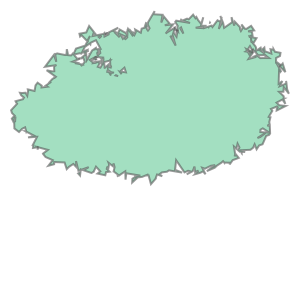

In [13]:
import shapely
geom1 = sample_geometry(ground_truth_geoms[0],50)
geom1.buffer(0)

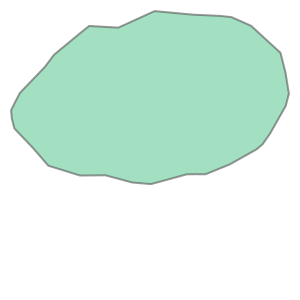

In [14]:
shapely.concave_hull(geom1.buffer(0), ratio=0.38)

In [15]:
ground_truth_geoms_fixed = []
for geom in ground_truth_geoms:
    poly = validate_geom(geom)
    ground_truth_geoms_fixed.append(poly)

## Observations (deviated and downsampled)

In [16]:
# Shift 400m to right
shiftx = 400
shifty = 0

initialidx = uuid.uuid4().hex
fpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{initialidx}.shp'
poly = Polygon(((cx-size/2+shiftx,cy-size/2+shifty), (cx-size/2+shiftx,cy+size/2+shifty), (cx+size/2+shiftx,cy+size/2+shifty), (cx+size/2+shiftx, cy-size/2+shifty)))

params = {'windspeed': 15, 'winddirection': 120, 'dt': datetime.timedelta(minutes=30)}

### Run forward simulations

In [17]:
observed_geoms = [poly]
for ix in range(14):
    simpoly = forward_pass(poly, params)
    observed_geoms.append(simpoly)
    poly = simpoly

Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '27397e9d8ffc484db8acbda655977ed8', 'compareidx': '28344fb2fdc148418c4af54fbb1bcd4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'a10cee32345548948735cdbb0f792888', 'compareidx': '0bd56d74107647319f35cc1d9e0176c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '809578cabe5649ed82431f96610abc06', 'compareidx': 'dd09a9970a354508b2c9bee960800604', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'ca2f1600fd8b4b35858fbfb340020396', 'compareidx': 'dfd8a91b51754fb99e9b86b78fa3e685', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'd0e458a55f504270ab4dade395eb820f', 'compareidx': '2369450b3f0142248f0fe038849e1072', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'cbf7f26291d84de3992a1cbfca12c6db', 'compareidx': '056d25461037463f98b859087c5e7fd4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2de06743390343e3a6e06bd6a7bfd7a9', 'compareidx': 'daa723688a384a1eaee2aaad77ea15d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'b815a322d2f34ccb8006c19c5911dd43', 'compareidx': 'd73f367567214a9f8c742d5f7197dbde', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3f1e63a03cb54eeb921d08dc123a05b9', 'compareidx': '1b67a5c210b14101886e0cf86368fc08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'ebe1f0bd9d5c464aab5a2fe618072952', 'compareidx': '0df5a869d83f4e97a6232263c19c238b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'ae60a24cf1f44bf8beaf768eb0125d98', 'compareidx': '1b7f83194c4c4fc3b7d1efe5e2a97e91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '1ef17ce6af2e4d3199c1953265d152a2', 'compareidx': 'ff03014959fb49b0966bdfccc2f73f8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8b4ebed996f427ca025dcdc86ff5286', 'compareidx': 'b7ea4384854c473d95d11ee868fe2125', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '2d03deee16b34898865ed0c2ba0efb3f', 'compareidx': '802d20bd47064b63a7cb317227277013', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


### Validate and downsample geometries

In [18]:
observed_geoms_fixed = []
for geom in observed_geoms:
    poly = validate_geom(geom)
    poly = validate_geom(interpolate_geom(poly, 100))
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    observed_geoms_fixed.append(poly)

## Plot Geometries

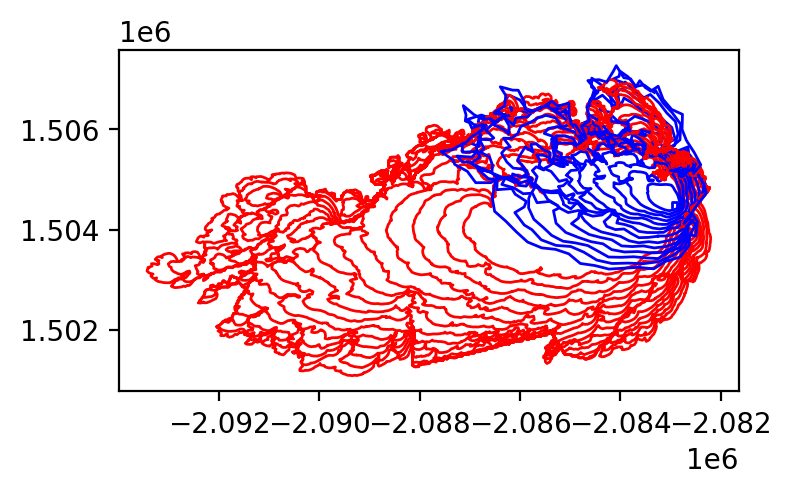

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for geom_truth, geom_observed in zip(ground_truth_geoms_fixed, observed_geoms_fixed):
    plot_geometry(geom_truth, ax=ax, color=(1,0,0), lw=1)
    plot_geometry(geom_observed, ax=ax, color=(0,0,1), lw=1)
    
    assert(geom_truth.is_valid), 'Ground truth Geometry is not valid'
    assert(geom_observed.is_valid), 'Observed Geometry is not valid'
    assert(isinstance(geom_observed, Polygon)), 'buffered polygon is not a polygon'
    
# plot_geometry(Polygon(gpd.read_file(usr.db.dfObservation.iloc[0]['filepath'])['geometry'][0]), ax=ax)
    
ax.set_aspect('equal')

In [20]:
with open('/home/jovyan/data/zeroinfo_simulations_08302023.pkl', 'wb') as f:
    pickle.dump(ground_truth_geoms_fixed, f)

## EnKF Update runs

In [ ]:
# ws = 10
# wd = 60 
######### wd and ws to be chosen from the runs during the live fire
nsamples = 500
vertex_count = 100

data = {'calculations': [],
        'parameters': {'nsamples': nsamples,
                       'vertex_count': vertex_count},
       }

windspeed = 15
winddirection = 120

In [ ]:
# for upix in range(len(wdar)):
#     sampled = sample_geometry(observed_geoms_fixed[1], sigma=500)
#     # Validate sample_poly
#     sampled_validated = validate_geom(sampled)
#     # Interpolate
#     sampled_validated_interpolated = interpolate_geom(sampled_validated, vertex_count)
#     # Validate again
#     sampled_validated_2 = validate_geom(sampled_validated_interpolated)

#     Y_geoms.append(sampled_validated_2)
    
# Y = geoms_to_matrix(Y_geoms, vertex_count=vertex_count)


In [ ]:
# plot_matrix_ensemble(Y, lw=0.1, color=(0,0,1,0.1))

In [ ]:
%%time

for upix in range(1,len(observed_geoms_fixed)):
    print('------------------------------------')
    print('------------------------------------')
    print(f'Calculating {upix-1}-->{upix}')
    print('------------------------------------')
    print('------------------------------------')
    
    # Generate samples of (ws, wd)
    wsar = np.array([windspeed]*nsamples)
    # wdar = np.random.uniform(inddirection-45, winddirection+45, size=nsamples)
    wdar = np.random.normal(winddirection, scale=15, size=nsamples)

    if upix == 1:# First ensemble, use generated samples from observed geometry
        initial_poly = observed_geoms_fixed[upix-1]
    else:
        # TODO: average of the state matrix
        Xmean = X.mean(axis=1)
        x,y = Xmean[::2], Xmean[1::2]
        initial_poly = Polygon(zip(x,y))
    
    Xt_geoms = []
    Y_geoms = []
    for i, (wsflt, wdflt) in enumerate(zip(wsar, wdar)):
        wsint = round(wsflt)
        wdint = np.fmod(round(wdflt)+360, 360)
        
        print(f'-- {upix-1}-->{upix} --\nCalculating wd={wdint}, ws={wsint} - {i}/{len(wdar)}')

        
        xtgeom = forward_pass(initial_poly, 
                              {'windspeed': wsint, 
                               'winddirection': wdint, 
                               'dt': datetime.timedelta(minutes=30)})
        if xtgeom is not None:
            Xt_geoms.append(xtgeom)
        
        sampled = sample_geometry(observed_geoms_fixed[upix], sigma=150)
        # Validate sample_poly
        sampled_validated = validate_geom(sampled)
        # Interpolate
        sampled_validated_interpolated = interpolate_geom(sampled_validated, vertex_count)
        # Validate again
        sampled_validated_2 = validate_geom(sampled_validated_interpolated)
        
        Y_geoms.append(sampled_validated_2)
        
    Y = geoms_to_matrix(Y_geoms, vertex_count=vertex_count, nsamples=nsamples)

    Ymean = Y.mean(axis=1)
    x,y = Ymean[::2], Ymean[1::2]
    aligned_geom = Polygon(zip(x,y))
    
    filled_count = nsamples-len(Xt_geoms)
    if filled_count > 0:
        Xt_geoms = fill_null_geoms(Xt_geoms, nsamples)
        
    Xt = geoms_to_matrix(Xt_geoms, vertex_count=vertex_count,  aligned_geom=aligned_geom, nsamples=nsamples)

    X = update_EnKF_2(Xt, Y)
    X = geoms_to_matrix(matrix_to_geom(X), vertex_count=vertex_count, aligned_geom = aligned_geom, nsamples=nsamples)
    
    data['calculations'].append({'initial_poly': initial_poly,
                                 'aligned_geom': aligned_geom,
                                 'filled_geoms': filled_count,
                                  'Xt': Xt, 'X': X, 'Y': Y,
                                  'wdar': wdar, 'wsar': wsar})
    
    with open('/home/jovyan/data/output_reftest_06202023.pkl', 'wb') as f:
        pickle.dump(data, f)
    
    if upix == 14:
        break

In [ ]:
print('test')

In [ ]:
# with open('/home/jovyan/data/output_reftest_06202023.pkl', 'wb') as f:
#     pickle.dump(data, f)

with open('/home/jovyan/data/output_reftest_08302023.pkl', 'wb') as f:
    pickle.dump(data, f)
    

## Plot filtered calculations

### Load pickle

In [ ]:
with open('/home/jovyan/data/output_reftest_08302023.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
calix = 13
Xt = data['calculations'][calix]['Xt']
Y = data['calculations'][calix]['Y']
X = data['calculations'][calix]['X']

plot_alix = None

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

# plot_matrix_ensemble(Xt, plot_alix =plot_alix, color=(0,0,1,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)
# plot_matrix_ensemble(Y, plot_alix=plot_alix, color=(1,0,0,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)
# plot_matrix_ensemble(X, plot_alix=plot_alix, color=(0,0,0,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)

show_stdev = True
plot_matrix(Xt, show_stdev=show_stdev, ax=ax, color='red')
plot_matrix(Y, show_stdev=show_stdev, ax=ax, color='blue')
plot_matrix(X, show_stdev=show_stdev, ax=ax, color='black', ls='--')

## Repeat Calculations for Maria Fire


In [21]:
# Collect observations
maria_observations = []
for i in range(10):
    dfrow = usr.db.dfObservation.iloc[i]
    geom = gpd.read_file(dfrow['filepath'])['geometry'][0]
    
    maria_observations.append(geom)
    
windspeed_maria = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
winddirection_maria = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

### Generate no-observation simulations

In [22]:
%%time

# zero concurrent observations
# Considers the first observation as the ignition
dfrow_ignite = usr.db.dfObservation.iloc[0]

timestamp = dfrow_ignite['datetime']
ignition_geom = gpd.read_file(dfrow_ignite['filepath'])['geometry'][0]

zero_info_simulations = [ignition_geom]
for i in range(10):
    dfrow_pre = usr.db.dfObservation.iloc[i]
    dfrow_next = usr.db.dfObservation.iloc[i+1]
    dt = dfrow_next['datetime'] - dfrow_pre['datetime']
    
    ignition_geom = forward_pass(ignition_geom, params={'winddirection': winddirection_maria[i],
                                                        'windspeed': windspeed_maria[i],
                                                        'dt': dt})
    zero_info_simulations.append(ignition_geom)

Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '703e8cfd5a8c47c5b62b904a48c52415', 'compareidx': 'c5d5b2f948fe43eba720f48fb863a60f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3ced3091cac7495ea899b930b58b4c18', 'compareidx': 'cbb32a8d461a4a1b9ab0cad5c70cdcac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '97aba253dd8d4aaebd888968ec0a301d', 'compareidx': '5dc116fedd664beb8bcc827826105ec6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fcf12e329c1d49b0acdfba87554ef50c', 'compareidx': 'de1f46605f9349feb8ee89f300e648f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '2b514c79acde4a2ca955becf4c1afc4f', 'compareidx': 'cb61f4c00d5547489e9c0ad05d97fc11', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '088a6091384d42278609d55e283d9f22', 'compareidx': '576b0b06de0848d7ad058c73c678f39c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '96ef52b28570454fbfffbb91b9a941fa', 'compareidx': '407c2cf47f0f43099d3070e160684901', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb1facc3c25640d6b34904a3ed274900', 'compareidx': 'bbfc398c431b41bbbee622153497900b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'a438432f5dd64b628e396072140b0489', 'compareidx': 'ed13cc421bbb475297d756d110c48d09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_931/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '11861e53ba604975b3d312d0d221f18a', 'compareidx': '1b2a9a02941a42a2b4475ee22b27b18a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
CPU times: user 659 ms, sys: 23.3 ms, total: 682 ms
Wall time: 18.8 s


In [23]:
zero_info_simulations

[<POLYGON ((-2084217.148 1503560.461, -2084279.557 1503576.755, -2084348.612 ...>,
 <POLYGON ((-2084991 1504442, -2084936 1504448, -2084907 1504477, -2084884 15...>,
 <POLYGON ((-2085377 1504125, -2085351 1504106, -2085325 1504086, -2085286 15...>,
 <POLYGON ((-2085851 1503900, -2085847 1503863, -2085841 1503826, -2085822 15...>,
 <POLYGON ((-2086563 1503341, -2086561 1503296, -2086553 1503250, -2086549 15...>,
 <POLYGON ((-2087232 1501829, -2087224 1501800, -2087217 1501770, -2087204 15...>,
 <POLYGON ((-2087491 1501632, -2087485 1501578, -2087434 1501552, -2087412 15...>,
 <POLYGON ((-2087792 1501904, -2087786 1501875, -2087779 1501845, -2087748 15...>,
 <POLYGON ((-2087950 1502384, -2087921 1502352, -2087902 1502340, -2087862 15...>,
 <POLYGON ((-2088100 1501586, -2088097 1501538, -2088090 1501500, -2088070 15...>,
 <POLYGON ((-2088172 1502148, -2088164 1502112, -2088149 1502097, -2088125 15...>]

In [24]:
with open('/home/jovyan/data/maria_zero_observation_sim_08312023.pkl', 'wb') as f:
    pickle.dump(zero_info_simulations, f)
    

### Validate observed geometries

In [ ]:
observed_geoms_fixed = []
for geom in maria_observations:
    poly = validate_geom(geom)
    poly = validate_geom(interpolate_geom(poly, 100))
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    observed_geoms_fixed.append(poly)

In [ ]:
# ws = 10
# wd = 60 
######### wd and ws to be chosen from the runs during the live fire
nsamples = 500
vertex_count = 100

data = {'calculations': [],
        'parameters': {'nsamples': nsamples,
                       'vertex_count': vertex_count},
       }

In [ ]:
plt.hist(np.random.normal(winddirection_maria[0], scale=30, size=nsamples))

In [ ]:
%%time

for upix in range(1,len(observed_geoms_fixed)):
    print('------------------------------------')
    print('------------------------------------')
    print(f'Calculating {upix-1}-->{upix}')
    print('------------------------------------')
    print('------------------------------------')
    
    # Generate samples of (ws, wd)
    
    # wsar = np.array([windspeed_maria]*nsamples)
    # wdar = np.random.uniform(inddirection-45, winddirection+45, size=nsamples)
    wsar = np.random.normal(windspeed_maria[upix-1], scale=3, size=nsamples)
    wdar = np.random.normal(winddirection_maria[upix-1], scale=30, size=nsamples)

    if upix == 1:# First ensemble, use the first observation as the ignition
        initial_poly = observed_geoms_fixed[upix-1]
    else:
        # TODO: average of the state matrix
        Xmean = X.mean(axis=1)
        x,y = Xmean[::2], Xmean[1::2]
        initial_poly = Polygon(zip(x,y))
    
    Xt_geoms = []
    Y_geoms = []
    for i, (wsflt, wdflt) in enumerate(zip(wsar, wdar)):
        wsint = round(wsflt)
        wdint = np.fmod(round(wdflt)+360, 360)
        
        print(f'-- {upix-1}-->{upix} --\nCalculating wd={wdint}, ws={wsint} - {i}/{len(wdar)}')

        
        xtgeom = forward_pass(initial_poly, 
                              {'windspeed': wsint, 
                               'winddirection': wdint, 
                               'dt': datetime.timedelta(minutes=30)})
        if xtgeom is not None:
            Xt_geoms.append(xtgeom)
        
        sampled = sample_geometry(observed_geoms_fixed[upix], sigma=150)
        # Validate sample_poly
        sampled_validated = validate_geom(sampled)
        # Interpolate
        sampled_validated_interpolated = interpolate_geom(sampled_validated, vertex_count)
        # Validate again
        sampled_validated_2 = validate_geom(sampled_validated_interpolated)
        
        Y_geoms.append(sampled_validated_2)
        
    Y = geoms_to_matrix(Y_geoms, vertex_count=vertex_count, nsamples=nsamples)

    Ymean = Y.mean(axis=1)
    x,y = Ymean[::2], Ymean[1::2]
    aligned_geom = Polygon(zip(x,y))
    
    filled_count = nsamples-len(Xt_geoms)
    if filled_count > 0:
        Xt_geoms = fill_null_geoms(Xt_geoms, nsamples)
        
    Xt = geoms_to_matrix(Xt_geoms, vertex_count=vertex_count,  aligned_geom=aligned_geom, nsamples=nsamples)

    X = update_EnKF_2(Xt, Y)
    X = geoms_to_matrix(matrix_to_geom(X), vertex_count=vertex_count, aligned_geom = aligned_geom, nsamples=nsamples)
    
    data['calculations'].append({'initial_poly': initial_poly,
                                 'aligned_geom': aligned_geom,
                                 'filled_geoms': filled_count,
                                  'Xt': Xt, 'X': X, 'Y': Y,
                                  'wdar': wdar, 'wsar': wsar})
    
    with open('/home/jovyan/data/output_maria_08302023.pkl', 'wb') as f:
        pickle.dump(data, f)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4,), dpi=200)
# plot_geometry(zero_info_simulations[1], ax=ax, color=(1,0,0,0.2))
# plot_geometry(zero_info_simulations[2], ax=ax, color=(1,0,0,0.4))
# plot_geometry(zero_info_simulations[3], ax=ax, color=(1,0,0,0.6))
plot_geometry(zero_info_simulations[4], ax=ax, color=(1,0,0,1))

# plot_matrix(data['calculations'][0]['X'], ax=ax, color=(0,0,1,0.2))
# plot_matrix(data['calculations'][1]['X'], ax=ax, color=(0,0,1,0.4))
# plot_matrix(data['calculations'][2]['X'], ax=ax, color=(0,0,1,0.6))
plot_matrix(data['calculations'][3]['X'], ax=ax, color=(0,0,1,1))

# plot_matrix(data['calculations'][0]['Y'], ax=ax, color=(0,0,0,0.2), ls='--')
# plot_matrix(data['calculations'][1]['Y'], ax=ax, color=(0,0,0,0.4), ls='--')
# plot_matrix(data['calculations'][2]['Y'], ax=ax, color=(0,0,0,0.6), ls='--')
plot_matrix(data['calculations'][3]['Y'], ax=ax, color=(0,0,0,1), ls='--')

In [ ]:
with open('/home/jovyan/data/output_maria_08302023.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
calix = 4
Xt = data['calculations'][calix]['Xt']
Y = data['calculations'][calix]['Y']
X = data['calculations'][calix]['X']

plot_alix = None

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

# plot_matrix_ensemble(Xt, plot_alix =plot_alix, color=(0,0,1,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)
# plot_matrix_ensemble(Y, plot_alix=plot_alix, color=(1,0,0,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)
# plot_matrix_ensemble(X, plot_alix=plot_alix, color=(0,0,0,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)

show_stdev = True
plot_matrix(Xt, show_stdev=show_stdev, ax=ax, color='red')
plot_matrix(Y, show_stdev=show_stdev, ax=ax, color='blue')
plot_matrix(X, show_stdev=show_stdev, ax=ax, color='black', ls='--')